In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# DTX Darshan logs

In [2]:
application_name = "nwchem"
postfix_name = ""
darshan_file = "../%s/darshan/%s%s.log" %(application_name, application_name, postfix_name)

## Read the metadata for the log

In [3]:
def read_metadata(filename):
    metadata = {}
    inf = open(filename)
    for line in inf:
        # ignore blank lines
        if len(line) < 2:
            continue
        # stop when the header section is finished
        if line[0] != "#":
            break
        delimiter = line.find(":")
        if delimiter == -1:
            continue
        key = line[2 : delimiter].lstrip().rstrip()
        value = line[delimiter + 1 : -1].lstrip().rstrip()
        if key not in metadata:
            metadata[key] = []
        metadata[key].append(value)
    inf.close()
    return metadata

In [4]:
metadata = read_metadata(darshan_file)

In [5]:
print("Metadata available for %s" %([i for i in metadata]))

Metadata available for ['darshan log version', 'compression method', 'exe', 'uid', 'jobid', 'start_time', 'start_time_asci', 'end_time', 'end_time_asci', 'nprocs', 'run time', 'metadata', 'header', 'job data', 'record table', 'POSIX module', 'STDIO module', 'DXT_POSIX module', 'mount entry', 'description of columns', '<module>', '<rank>', '<record id>', '<counter name> and <counter value>', '<file name>', '<mount pt>', '<fs type>', 'description of POSIX counters', 'POSIX_*', 'POSIX_RENAME_SOURCES/TARGETS', 'POSIX_RENAMED_FROM', 'POSIX_MODE', 'POSIX_BYTES_*', 'POSIX_MAX_BYTE_*', 'POSIX_CONSEC_*', 'POSIX_SEQ_*', 'POSIX_RW_SWITCHES', 'POSIX_*_ALIGNMENT', 'POSIX_*_NOT_ALIGNED', 'POSIX_MAX_*_TIME_SIZE', 'POSIX_SIZE_*_*', 'POSIX_STRIDE*_STRIDE', 'POSIX_STRIDE*_COUNT', 'POSIX_ACCESS*_ACCESS', 'POSIX_ACCESS*_COUNT', 'POSIX_*_RANK', 'POSIX_*_RANK_BYTES', 'POSIX_F_*_START_TIMESTAMP', 'POSIX_F_*_END_TIMESTAMP', 'POSIX_F_READ/WRITE/META_TIME', 'POSIX_F_MAX_*_TIME', 'POSIX_F_*_RANK_TIME', 'POSIX_F_

In [6]:
print("Darshan version: %s" %(metadata["darshan log version"]))

Darshan version: ['3.10']


## Read the Darshan log

In [7]:
# Darshan files have the following format:
# <module> <rank> <record id> <counter> <value> <file name> <mount pt> <fs type>

df = pd.read_csv(darshan_file, delimiter='\t', comment='#',
                 names=['IOType', 'Rank', 'RecordID', 'Counter', 'Value',
                        'FileName', 'MountPt', 'FSType'])
# Needed by the aggregated plots
df["Count"] = 1
df.head()

,IOType,Rank,RecordID,Counter,Value,FileName,MountPt,FSType,Count
0,POSIX,0,1828374797521024576,POSIX_OPENS,2.0,/gpfs/alpine/csc143/proj-shared/againaru/nwche...,/gpfs/alpine,gpfs,1
1,POSIX,0,1828374797521024576,POSIX_FILENOS,0.0,/gpfs/alpine/csc143/proj-shared/againaru/nwche...,/gpfs/alpine,gpfs,1
2,POSIX,0,1828374797521024576,POSIX_DUPS,0.0,/gpfs/alpine/csc143/proj-shared/againaru/nwche...,/gpfs/alpine,gpfs,1
3,POSIX,0,1828374797521024576,POSIX_READS,9.0,/gpfs/alpine/csc143/proj-shared/againaru/nwche...,/gpfs/alpine,gpfs,1
4,POSIX,0,1828374797521024576,POSIX_WRITES,0.0,/gpfs/alpine/csc143/proj-shared/againaru/nwche...,/gpfs/alpine,gpfs,1


## Log Summary

In [8]:
log_summary = {}
log_summary["Walltime"] = int(metadata["run time"][0])
log_summary["Total_ranks"] = int(metadata["nprocs"][0])
log_summary["IO_Types"] = df['IOType'].unique()
log_summary["FS_Types"] = df['FSType'].unique()
log_summary["#ranks_involved"] = len(df['Rank'].unique())
log_summary["#files_accessed"] = len(df['FileName'].unique())

# Get access size for each IO type
log_summary["Access_size_bytes"] = {}
for i in log_summary["IO_Types"]:
    value = metadata["%s module" %(i)][0]
    # Assuming all logs record bytes
    value = value[:value.find(" ")]
    log_summary["Access_size_bytes"][i] = int(value)

In [9]:
print("Stats for %s%s" %(application_name, postfix_name))
print("---------")
for i in log_summary:
    print(i, log_summary[i])

Stats for nwchem
---------
Walltime 177
Total_ranks 224
IO_Types ['POSIX' 'STDIO']
FS_Types ['gpfs' 'UNKNOWN']
#ranks_involved 224
#files_accessed 468
Access_size_bytes {'POSIX': 37034, 'STDIO': 414}


# Plot Darshan statistics

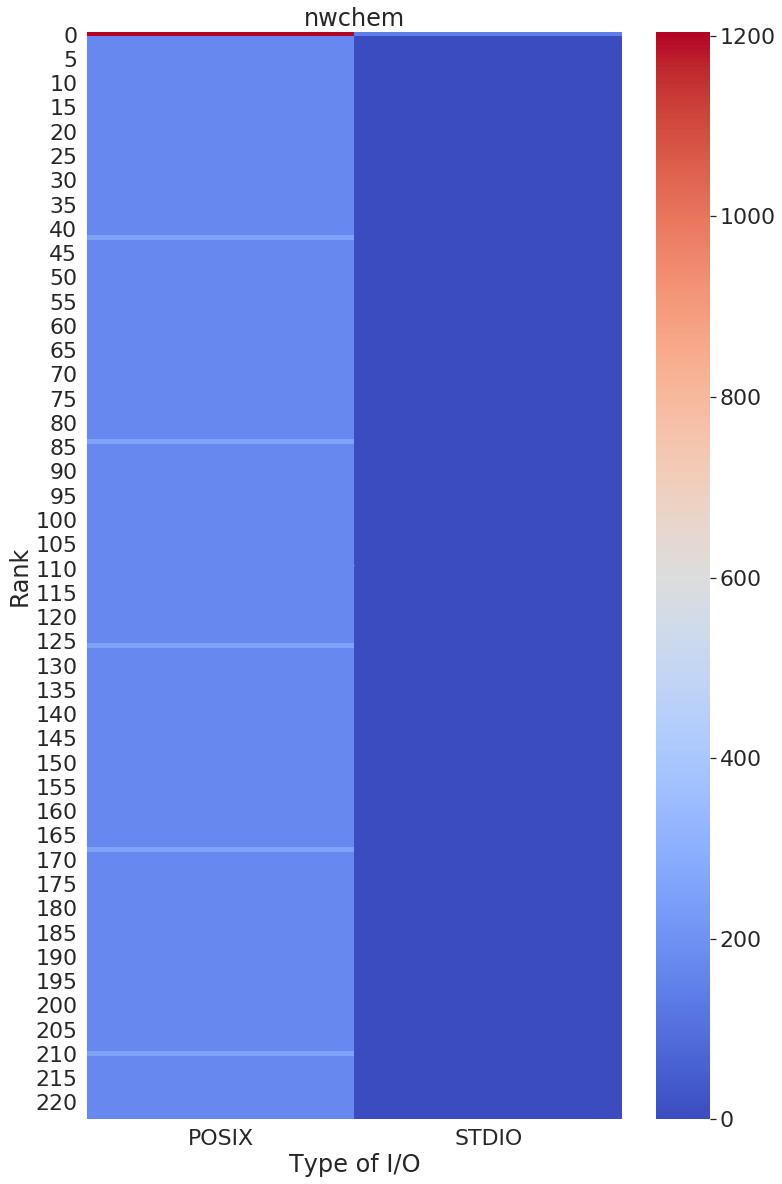

In [12]:
piv = pd.pivot_table(df, values="Count",index=["Rank"], columns=["IOType"], fill_value=0, aggfunc=np.sum)

sns.set(font_scale=2)
sns.set_style("white")
fig, ax = plt.subplots(figsize=(12,20))
sns.heatmap(piv, cmap='coolwarm')

ax.set_xlabel('Type of I/O')
ax.set_ylabel('Rank')
ax.set_title("%s%s" %(application_name, postfix_name))
plt.savefig("%s%s_iotype_rank.png" %(application_name, postfix_name),
            bbox_inches = 'tight')
plt.show()